# Support Vector Machine Assignment on Amazon Food Review

# Introduction

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

## Objective:
#### To Predict the Polarity of Amazon Fine Food Review Using Support-Vector-Machine Algorithm

#### Apply Support-Vector-Machine Algorithm on
1. Bow(Bag of Words)
2. TF-IDF
3. Average Word2Vec
4. tf-idf Word2Vec

#### Try out both Linear as well as RBF kernel
#### Try out CalibratedClassifierCV on Linear Kernel SVC
#### Find out  10 importnant Features from positive and negative class
#### Properly document the results according to the instructions provided in the corresponding ipynb

### [Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review

### Steps :

#### We will perform following steps for classifying the review as positive or Negative:
##### 1.Importing data 
##### 2.Preparing that data
##### 3.Choosing a model
##### 4.Training
##### 5.Evaluation
##### 6.Hyperparameter tuning
##### 7.Prediction.

# Importing Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
import os
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import preprocessing
from sklearn import metrics

In [5]:
import math
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score
from sklearn.svm import SVC

In [6]:
import sqlite3
if os.path.isfile("final.sqlite"):
    conn=sqlite3.connect("final.sqlite")
    Data=pd.read_sql_query("select * from Logistic_Regression_Data where Score!=3",conn)
    conn.close()
else :
    print("Error Importing the file")

In [7]:
print("Number of Reviews: ",Data["Text"].count())
print("Number of Users: ",len(Data["UserId"].unique())) 
print("Number of Products: ",len(Data["ProductId"].unique()))
print("Shape of Data: ",Data.shape)
print("\n",Data.columns)
print("Number of Attributes/Columns in data: 12") 
print("Number of Positive Reviews : ", Data['Score'].value_counts()[1])
print("Number of Negative Reviews : ", Data['Score'].value_counts()[0])

Number of Reviews:  150000
Number of Users:  115887
Number of Products:  42869
Shape of Data:  (150000, 13)

 Index(['level_0', 'index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')
Number of Attributes/Columns in data: 12
Number of Positive Reviews :  126413
Number of Negative Reviews :  23587


In [8]:
# Sorting on the basis of Time Parameter
Data.sort_values('Time',inplace=True)
Data = Data.sample(n=100000)
Data['Score'].value_counts()
X = Data['CleanedText'].values
y = Data['Score'].values

In [9]:
# X = A
# Y = b
rbf = Data.sample(n = 20000)
A = rbf['CleanedText'].values
b = rbf['Score'].values

## Splitting the data into train and test set

In [10]:
#splitting for linear kernel
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size = 0.33,shuffle='false')

In [11]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(67000,) (67000,)
(33000,) (33000,)


In [12]:
#splitting for rbf kernel
A_train, A_test , b_train , b_test = train_test_split(A,b,test_size = 0.33,shuffle='false')

In [13]:
print(A_train.shape,b_train.shape)
print(A_test.shape,b_test.shape)

(13400,) (13400,)
(6600,) (6600,)


## Hyperparameter

In [14]:
estimate = {'C' : [0.001, 0.01, 0.1, 1, 10] ,'gamma' : [0.001, 0.01, 0.1, 1,10]}

## Reusable codes

In [15]:
#confusion matrix
def confusionmatrix(model,X,y):
    ob = confusion_matrix(y,model.predict(X))
    label = ['NEGATIVE','POSITIVE']
    df = pd.DataFrame(ob,index=label,columns=label)
    sns.heatmap(df,annot=True,fmt ='d')

In [16]:
#findbestparameter
def findbestparameter(model,X,y):
    parameter = estimate
    tscv = TimeSeriesSplit(n_splits=10)
    gs = RandomizedSearchCV(model,param_distributions = parameter ,verbose=1,scoring='roc_auc',cv=tscv)
    gs.fit(X,y)
    return gs

In [17]:
#auc-curve
def plot_auc(model,X,y):
    parameter = {'C':[0.001, 0.01, 0.1, 1, 10]}
    tscv = TimeSeriesSplit(n_splits=10)
    gscv = RandomizedSearchCV(model,param_distributions = parameter,verbose=1,scoring='roc_auc',cv=tscv)
    gscv.fit(X,y)
    results=gscv.cv_results_
    train_auc=[x for x in results['mean_train_score']]
    cv_auc=[x for x in results['mean_test_score']]
    estimate = {'C' : [0.001, 0.01, 0.1, 1, 10] }
    log_c=[math.log10(x) for x in estimate['C'] ]
    plt.plot(log_c, train_auc, label='Train AUC')
    plt.plot(log_c, cv_auc, label='CV AUC')
    plt.legend()
    plt.xlabel("Log(c): hyperparameter")
    plt.ylabel("AUC")
    plt.title("Plot Between Missclassification Error & Log(c)")
    plt.show()

In [18]:
#imporntantfeatures
def important_features(vectorizer,model,n=10):
    
    Weights_Index = model.coef_[0].argsort()
    length = len(Weights_Index)
    # For Negative Class
    neg_class=Weights_Index[:10]
    
    neg_feat=[vectorizer.get_feature_names()[x] for x in neg_class]
    neg_prob=[model.coef_[0][x] for x in neg_class]
    
    neg_zip=list(zip(neg_feat,neg_prob))
    neg_zip.sort()
    
    # For Positive Class 
    pos_class =  Weights_Index[-10:]
    
    pos_feat=[vectorizer.get_feature_names()[x] for x in pos_class]
    pos_prob=[model.coef_[0][x] for x in pos_class]
    pos_zip=list(zip(pos_feat,pos_prob))
    pos_zip.sort()
    
    top=zip(pos_zip,neg_zip)
    
    print("{0:20}{1:55}{2:20}".format("S.N","Positive","Negative"))
    print("_"*90)
    i=1
    for (fn_1,coef_1), (fn_2,coef_2) in top:
        print("%d.\t\t%.3f\t%-30s\t\t%.3f\t%s" % (i,coef_1, fn_1, coef_2, fn_2))
        i+=1
    

In [19]:
#Plot ROC_AUC Curve

def plot_auc_roc(model,X_train,X_test,y_train,y_test):
    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("Alpha: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ROC CURVE PLOTS")
    plt.show()

In [20]:
# predict uncalibrated probabilities
def uncalibrated(model, trainX, testX, trainy):
    model.fit(trainX, trainy)
    # predict probabilities
    return model.decision_function(testX)
 
# predict calibrated probabilities
def calibrated(model,trainX, testX, trainy):
    # define and fit calibration model
    calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
    calibrated.fit(trainX, trainy)
    # predict probabilities
    return calibrated.predict_proba(testX)[:, 1]
 

In [21]:
def roc_calibrated(model,X_train, X_test, y_train,y_test):
    calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
    calibrated.fit(X_train, y_train)
    train_fpr, train_tpr, thresholds = roc_curve(y_train, calibrated.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, calibrated.predict_proba(X_test)[:,1])
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("Alpha: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ROC CURVE PLOTS")
    plt.show()

In [30]:
# Linear_hyperparameter Plot

def plot(model,X,y):
    parameter = {'alpha' : [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
    gs = GridSearchCV(model,param_grid = parameter , cv = 10 ,verbose=0)
    gs.fit(X,y)
    
    results = gs.cv_results_
    train_res = results['mean_train_score']
    cv_res = results['mean_test_score']
    
    log_para = [math.log(x) for x in parameter['alpha']]
    plt.plot(log_para,train_res,label = 'train_score')
    plt.plot(log_para,cv_res,label = 'cv_score')
    plt.xlabel('log(alpha)')
    plt.ylabel('mean_score')
    plt.legend()
    plt.show()

# Linear Bags of Words

In [24]:
vect = CountVectorizer(min_df = 10 , max_features = 500)
vect.fit(X_train)
X_train_bow = preprocessing.normalize(vect.transform(X_train))
X_test_bow = preprocessing.normalize(vect.transform(X_test))

print("Shape of Train and Test Data After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

Shape of Train and Test Data After vectorizations
(67000, 500) (67000,)
(33000, 500) (33000,)


In [26]:
model = SGDClassifier(class_weight='balanced')

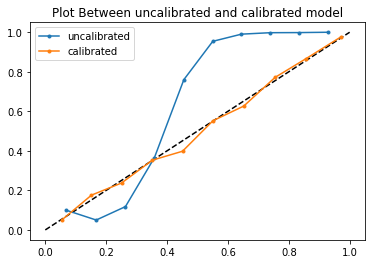

In [62]:
# uncalibrated predictions
yhat_uncalibrated = uncalibrated(model,X_train_bow, X_test_bow, y_train)
# calibrated predictions
yhat_calibrated = calibrated(model,X_train_bow, X_test_bow, y_train)
# reliability diagrams
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, yhat_uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, yhat_calibrated, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.',label = 'uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.',label = 'calibrated')
plt.legend()
plt.title("Plot Between uncalibrated and calibrated model")
plt.show()

In [66]:
ccv = CalibratedClassifierCV(model,method='sigmoid',cv=10)
ccv.fit(X_train_bow ,y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [67]:
prob_test = ccv.predict_proba(X_test_bow)[:, 1]
fop_test, mpv_test = calibration_curve(y_test, prob_test, n_bins=10, normalize=True)
prob_train = ccv.predict_proba(X_train_bow)[:, 1]
fop_train, mpv_train = calibration_curve(y_train, prob_train, n_bins=10, normalize=True)

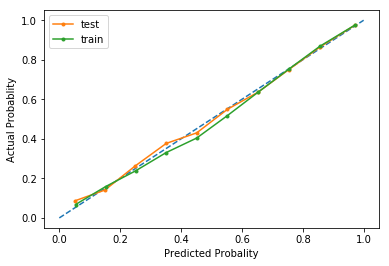

In [68]:
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv_test, fop_test, marker='.',label = 'test')
plt.plot(mpv_train, fop_train, marker='.' , label ='train')
plt.xlabel('Predicted Probality')
plt.ylabel('Actual Probablity')
plt.legend()
plt.show()

In [69]:
parameters = ccv.get_params()
parameters['base_estimator__alpha']

0.0001

### Hyperparameter plot

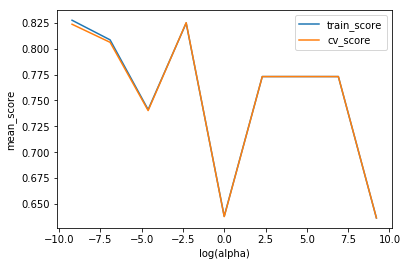

In [31]:
plot(model,X_train_bow,y_train)

In [70]:
model =SGDClassifier(alpha = 0.0001 ,class_weight='balanced')
model.fit(X_train_bow,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

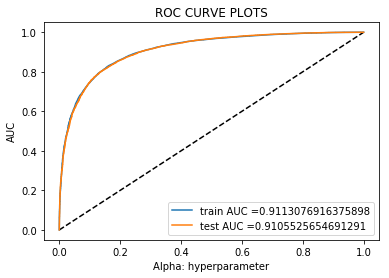

In [66]:
roc_calibrated(X_train_bow, X_test_bow, y_train,y_test)

### Confusion Matrices

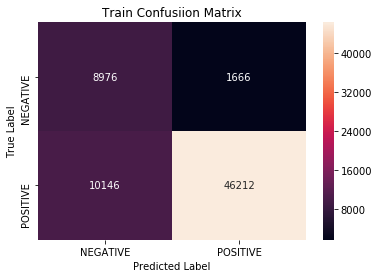

In [71]:
#ploting Confusion matrix
confusionmatrix(model,X_train_bow,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

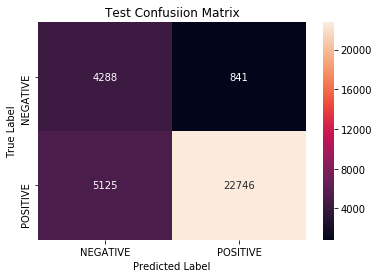

In [72]:
#ploting Confusion matrix
confusionmatrix(model,X_test_bow,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Classification Report

In [73]:
print("Classification Report: \n")
y_pred=model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.46      0.84      0.59      5129
           1       0.96      0.82      0.88     27871

   micro avg       0.82      0.82      0.82     33000
   macro avg       0.71      0.83      0.74     33000
weighted avg       0.89      0.82      0.84     33000



### 10 most important feature

In [74]:
important_features(vect,model,n=10)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		3.669	amaz                          		-2.496	away
2.		3.198	awesom                        		-3.004	bad
3.		4.512	best                          		-1.945	didnt
4.		4.898	delici                        		-4.991	disappoint
5.		4.069	excel                         		-2.169	hope
6.		3.332	favorit                       		-2.240	mayb
7.		4.244	great                         		-2.535	money
8.		3.316	nice                          		-1.969	stick
9.		4.455	perfect                       		-2.572	thought
10.		3.111	smooth                        		-3.020	wast


## RBF Bags of Words

In [21]:
vect = CountVectorizer(min_df = 10 , max_features = 500)
vect.fit(A_train)
A_train_bow = preprocessing.normalize(vect.transform(A_train))
A_test_bow = preprocessing.normalize(vect.transform(A_test))

print("Shape of Train and Test Data After vectorizations")
print(A_train_bow.shape, b_train.shape)
print(A_test_bow.shape, b_test.shape)

Shape of Train and Test Data After vectorizations
(13400, 500) (13400,)
(6600, 500) (6600,)


In [22]:
model = SVC(class_weight='balanced')

In [99]:
gsv = findbestparameter(model,A_train_bow,b_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 66.0min finished


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 90.0min finished


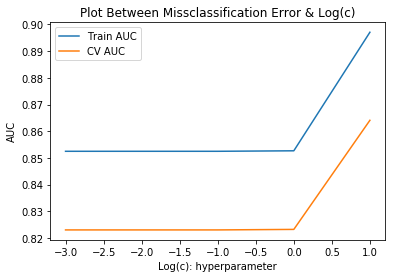

In [24]:
X = A_train_bow
y = b_train
plot_auc(model,X,y)

In [23]:
gsv.best_params_

{'gamma': 1, 'C': 1}

In [24]:
Best_param=gsv.best_params_
model = SVC(C=1,gamma=1,class_weight='balanced',probability=True) 
model.fit(A_train_bow,b_train)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

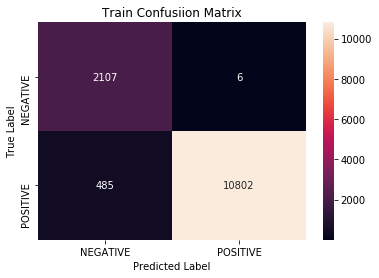

In [25]:
#ploting Confusion matrix
confusionmatrix(model,A_train_bow,b_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

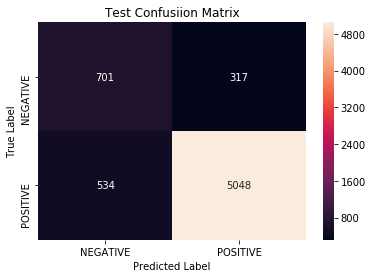

In [26]:
#ploting Confusion matrix
confusionmatrix(model,A_test_bow,b_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC Curve

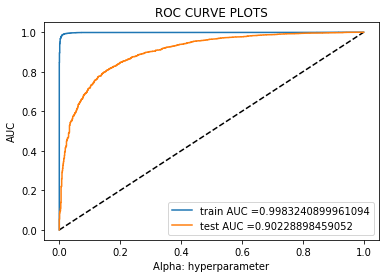

In [27]:
plot_auc_roc(model,A_train_bow,A_test_bow,b_train,b_test)

### Classification Report

In [28]:
print("Classification Report: \n")
y_pred=model.predict(A_test_bow)
print(classification_report(b_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.57      0.69      0.62      1018
           1       0.94      0.90      0.92      5582

   micro avg       0.87      0.87      0.87      6600
   macro avg       0.75      0.80      0.77      6600
weighted avg       0.88      0.87      0.88      6600



## Linear Tf-idf

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [33]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [34]:
X_train_tfidf = preprocessing.normalize(vectorizer.transform(X_train))
X_test_tfidf = preprocessing.normalize(vectorizer.transform(X_test))

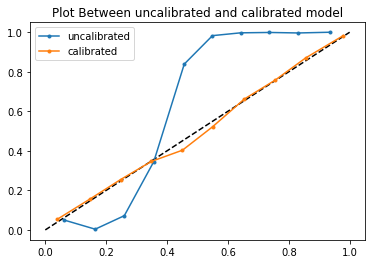

In [70]:
model = SGDClassifier(class_weight='balanced')
# uncalibrated predictions
yhat_uncalibrated = uncalibrated(model,X_train_tfidf, X_test_tfidf, y_train)
# calibrated predictions
yhat_calibrated = calibrated(model,X_train_tfidf, X_test_tfidf, y_train)
# reliability diagrams
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, yhat_uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, yhat_calibrated, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.',label = 'uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.',label = 'calibrated')
plt.legend()
plt.title("Plot Between uncalibrated and calibrated model")
plt.show()

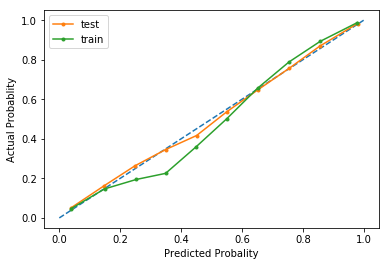

In [71]:
ccv = CalibratedClassifierCV(model,method='sigmoid',cv=10)
ccv.fit(X_train_tfidf ,y_train)
prob_test = ccv.predict_proba(X_test_tfidf)[:, 1]
fop_test, mpv_test = calibration_curve(y_test, prob_test, n_bins=10, normalize=True)
prob_train = ccv.predict_proba(X_train_tfidf)[:, 1]
fop_train, mpv_train = calibration_curve(y_train, prob_train, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv_test, fop_test, marker='.',label = 'test')
plt.plot(mpv_train, fop_train, marker='.' , label ='train')
plt.xlabel('Predicted Probality')
plt.ylabel('Actual Probablity')
plt.legend()
plt.show()

### Hyperparmeter plot

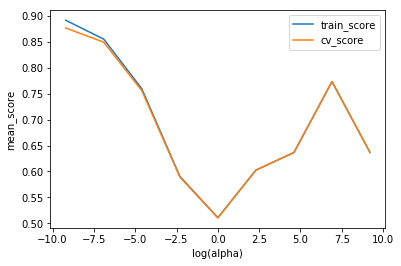

In [35]:
plot(model,X_train_tfidf,y_train)

In [72]:
parameters = ccv.get_params()
parameters['base_estimator__alpha']
model =SGDClassifier(alpha = 0.0001 ,class_weight='balanced')
model.fit(X_train_tfidf,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

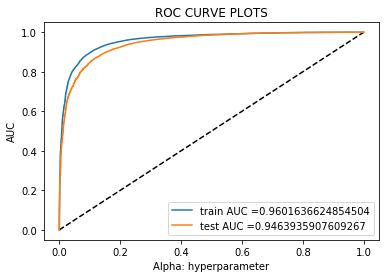

In [74]:
roc_calibrated(X_train_tfidf, X_test_tfidf, y_train,y_test)

### Confusion Matrix

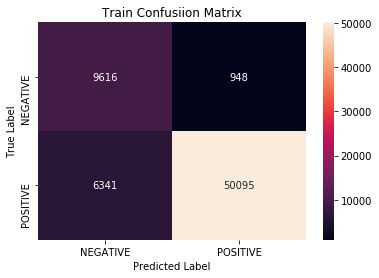

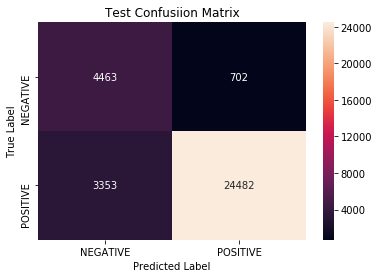

In [29]:
#ploting Confusion matrix
confusionmatrix(model,X_train_tfidf,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
#ploting Confusion matrix
confusionmatrix(model,X_test_tfidf,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Classification Report

In [30]:
print("Classification Report: \n")
y_pred=model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.57      0.86      0.69      5165
           1       0.97      0.88      0.92     27835

   micro avg       0.88      0.88      0.88     33000
   macro avg       0.77      0.87      0.81     33000
weighted avg       0.91      0.88      0.89     33000



### 10 Importnant Features

In [32]:
important_features(vectorizer,model,n=10)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		3.046	amaz                          		-3.316	aw
2.		5.237	best                          		-5.209	disappoint
3.		4.676	delici                        		-2.967	horribl
4.		4.236	excel                         		-2.732	stale
5.		3.680	favorit                       		-2.807	tasteless
6.		3.524	good                          		-3.430	terribl
7.		6.049	great                         		-2.656	thought
8.		5.000	love                          		-3.341	unfortun
9.		3.456	nice                          		-2.868	weak
10.		4.261	perfect                       		-3.619	worst


## RBF TF_IDF

In [25]:
vect = CountVectorizer(min_df = 10 , max_features = 500)
vect.fit(A_train)
A_train_tfidf = preprocessing.normalize(vect.transform(A_train))
A_test_tfidf = preprocessing.normalize(vect.transform(A_test))

print("Shape of Train and Test Data After vectorizations")
print(A_train_tfidf.shape, b_train.shape)
print(A_test_tfidf.shape, b_test.shape)

Shape of Train and Test Data After vectorizations
(13400, 500) (13400,)
(6600, 500) (6600,)


In [26]:
model = SVC(class_weight='balanced')

In [31]:
gsv = findbestparameter(model,A_train_tfidf,b_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 73.0min finished


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 29.6min finished


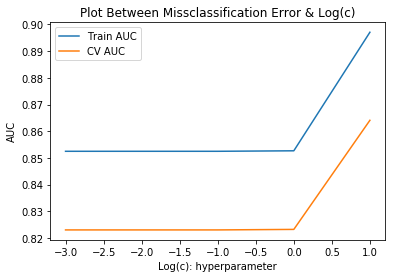

In [27]:
X = A_train_tfidf
y = b_train
plot_auc(model,X,y)

In [33]:
gsv.best_params_

{'gamma': 1, 'C': 1}

### Training the model

In [34]:
model = SVC(C=1,gamma=1,class_weight='balanced',probability=True) 
model.fit(A_train_tfidf,b_train)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Confusion Matrix

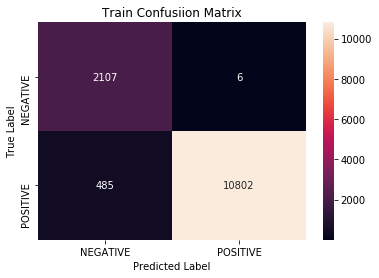

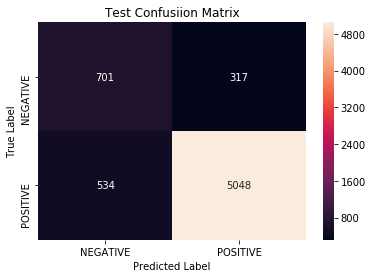

In [35]:
#ploting Confusion matrix
confusionmatrix(model,A_train_tfidf,b_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
#ploting Confusion matrix
confusionmatrix(model,A_test_tfidf,b_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC-AUC Curve

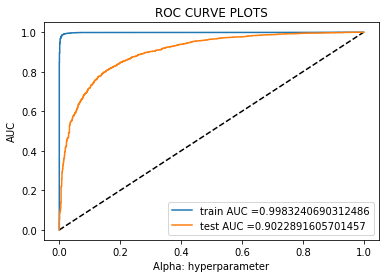

In [36]:
plot_auc_roc(model,A_train_tfidf,A_test_tfidf,b_train,b_test)

### CLassification Report

In [37]:
print("Classification Report: \n")
y_pred=model.predict(A_test_tfidf)
print(classification_report(b_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.57      0.69      0.62      1018
           1       0.94      0.90      0.92      5582

   micro avg       0.87      0.87      0.87      6600
   macro avg       0.75      0.80      0.77      6600
weighted avg       0.88      0.87      0.88      6600



## Word2Vec

In [36]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [37]:
list_of_Train_sent=[]
list_of_Test_sent=[]

for sent in X_train:
    list_of_Train_sent.append(sent.split())
    
for sent in X_test:
    list_of_Test_sent.append(sent.split())

In [38]:
list_of_Train_sentA=[]
list_of_Test_sentA=[]

for sent in A_train:
    list_of_Train_sentA.append(sent.split())
    
for sent in A_test:
    list_of_Test_sentA.append(sent.split())

In [39]:
model=Word2Vec(list_of_Train_sent,min_count=5,size=50, workers=4)

In [40]:
modelA=Word2Vec(list_of_Train_sentA,min_count=5,size=50, workers=4)

## Av. Word2Vec

In [41]:
import numpy as np

Train_vectors = []
for sent in list_of_Train_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectors.append(sent_vec)
Train_vectors = np.nan_to_num(Train_vectors)

In [42]:
Test_vectors=[]
for sent in list_of_Test_sent:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        try:
            vec=model.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectors.append(sent_vec)
Test_vectors=np.nan_to_num(Test_vectors)   

In [43]:
print("Shape of Test Vectors : ",Test_vectors.shape)

Shape of Test Vectors :  (33000, 50)


In [44]:
X_train_w2v = Train_vectors
X_test_w2v = Test_vectors

In [45]:
import numpy as np

Train_vectorsA = []
for sent in list_of_Train_sentA:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = modelA.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectorsA.append(sent_vec)
Train_vectorsA = np.nan_to_num(Train_vectorsA)

In [46]:
Test_vectorsA=[]
for sent in list_of_Test_sentA:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        try:
            vec=modelA.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectorsA.append(sent_vec)
Test_vectorsA=np.nan_to_num(Test_vectorsA)   

In [47]:
A_train_w2v = Train_vectorsA
A_test_w2v = Test_vectorsA

## Linear Av . Word2Vec

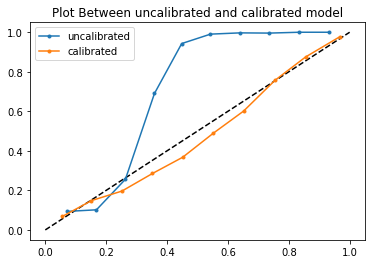

In [62]:
model = SGDClassifier(class_weight='balanced')
# uncalibrated predictions
yhat_uncalibrated = uncalibrated(model,X_train_w2v, X_test_w2v, y_train)
# calibrated predictions
yhat_calibrated = calibrated(model,X_train_w2v, X_test_w2v, y_train)
# reliability diagrams
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, yhat_uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, yhat_calibrated, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.',label = 'uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.',label = 'calibrated')
plt.legend()
plt.title("Plot Between uncalibrated and calibrated model")
plt.show()

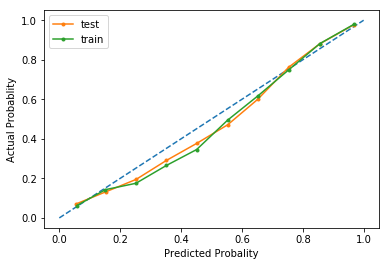

In [63]:
ccv = CalibratedClassifierCV(model,method='sigmoid',cv=10)
ccv.fit(X_train_w2v ,y_train)
prob_test = ccv.predict_proba(X_test_w2v)[:, 1]
fop_test, mpv_test = calibration_curve(y_test, prob_test, n_bins=10, normalize=True)
prob_train = ccv.predict_proba(X_train_w2v)[:, 1]
fop_train, mpv_train = calibration_curve(y_train, prob_train, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv_test, fop_test, marker='.',label = 'test')
plt.plot(mpv_train, fop_train, marker='.' , label ='train')
plt.xlabel('Predicted Probality')
plt.ylabel('Actual Probablity')
plt.legend()
plt.show()

In [49]:
model_w2v = SGDClassifier(class_weight='balanced')

### Hyperparameter Plot

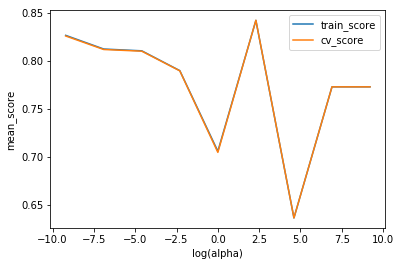

In [50]:
plot(model_w2v,X_train_w2v,y_train)

In [90]:
parameters = ccv.get_params()
parameters['base_estimator__alpha']
modelw2v =SGDClassifier(alpha = 0.0001 ,class_weight='balanced')
modelw2v.fit(X_train_w2v,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

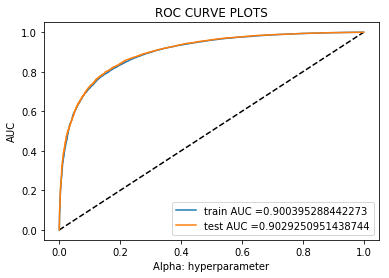

In [91]:
roc_calibrated(modelw2v,X_train_w2v, X_test_w2v, y_train,y_test)

### Confusion Matrix

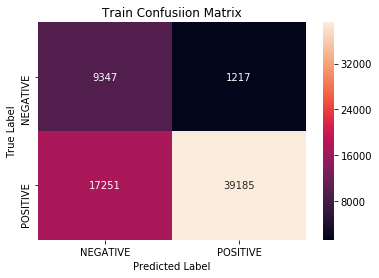

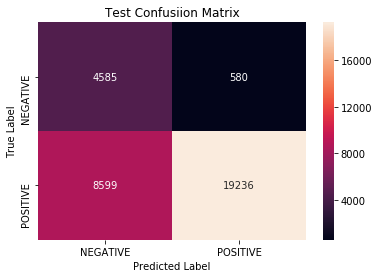

In [56]:
#ploting Confusion matrix
confusionmatrix(model,X_train_w2v,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
#ploting Confusion matrix
confusionmatrix(model,X_test_w2v,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### CLassificarion Report

In [57]:
print("Classification Report: \n")
y_pred=model.predict(X_test_w2v)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.35      0.89      0.50      5165
           1       0.97      0.69      0.81     27835

   micro avg       0.72      0.72      0.72     33000
   macro avg       0.66      0.79      0.65     33000
weighted avg       0.87      0.72      0.76     33000



## RBF Av. Word2Vec

In [36]:
model = SVC(class_weight='balanced')

In [27]:
gsv = findbestparameter(model,A_train_w2v,b_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.3min finished


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  9.2min finished


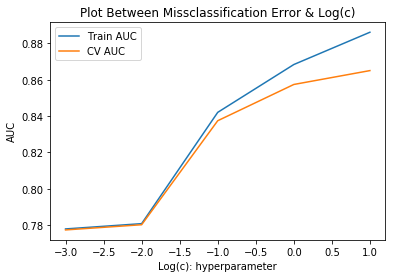

In [37]:
X = A_train_w2v
y = b_train
plot_auc(model,X,y)

### Training the model

In [35]:
rbf_model = SVC(C=1,gamma= 1,class_weight='balanced',probability=True) 
rbf_model.fit(A_train_w2v,b_train)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Confusion Matrix

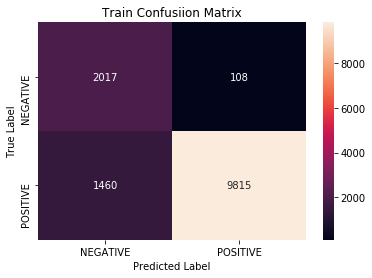

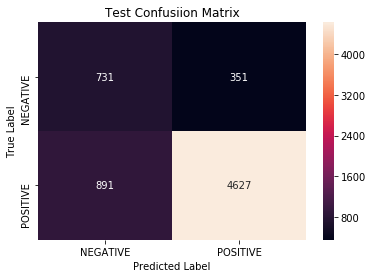

In [36]:
#ploting Confusion matrix
confusionmatrix(rbf_model,A_train_w2v,b_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
#ploting Confusion matrix
confusionmatrix(rbf_model,A_test_w2v,b_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC-AUC Curve

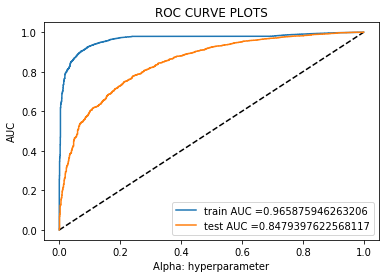

In [37]:
plot_auc_roc(rbf_model,A_train_w2v,A_test_w2v,b_train,b_test)

### Classifcation Report

In [38]:
print("Classification Report: \n")
y_pred=rbf_model.predict(A_test_w2v)
print(classification_report(b_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.45      0.68      0.54      1082
           1       0.93      0.84      0.88      5518

   micro avg       0.81      0.81      0.81      6600
   macro avg       0.69      0.76      0.71      6600
weighted avg       0.85      0.81      0.83      6600



## tf-idf Word2Vec

In [51]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [52]:
vectorizerA = TfidfVectorizer()
vectorizerA.fit(A_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [53]:
X_train_tfidf=vectorizer.transform(X_train)
X_train_tfidf=preprocessing.normalize(X_train_tfidf)

X_test_tfidf=vectorizer.transform(X_test)
X_test_tfidf=preprocessing.normalize(X_test_tfidf)

In [70]:
A_train_tfidf=vectorizerA.transform(A_train)
A_train_tfidf=preprocessing.normalize(A_train_tfidf)

A_test_tfidf=vectorizerA.transform(A_test)
A_test_tfidf=preprocessing.normalize(A_test_tfidf)

In [53]:
from tqdm import tqdm
Train_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Train_sent):
    sent_vec=np.zeros(50)
    weight=0
    for word in sent:
        try :
            w2v_vec=model.wv[word]
            tfidf_vec=X_train_tfidf[row,TFIDF_Feature.index(word)]
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf_vec
            
        except :
            pass
    if weight!=0:
        sent_vec/=weight
    Train_TFIDF_W2V_Vectors.append(sent_vec) 
    row+=1

100%|██████████████████████████████████| 67000/67000 [00:08<00:00, 8302.07it/s]


In [54]:
Test_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Test_sent):
    sent_vec=np.zeros(50)
    weight=0
    
    for word in sent:
        try:
            w2v_vec=model.wv[word]
            tfidf_vec=X_test_tfidf(row,TFIDF_Feature.index(word))
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf
          
        except :
            pass
    
    if weight!=0:
        sent_vec/=weight
    Test_TFIDF_W2V_Vectors.append(sent_vec)    
    row+=1

100%|██████████████████████████████████| 33000/33000 [00:03<00:00, 8529.03it/s]


In [55]:
Train_TFIDF_W2V_Vectors = np.nan_to_num(Train_TFIDF_W2V_Vectors)
Test_TFIDF_W2V_Vectors = np.nan_to_num(Test_TFIDF_W2V_Vectors)

In [56]:
X_train_w2v=Train_TFIDF_W2V_Vectors
X_test_w2v=Test_TFIDF_W2V_Vectors
print(X_train_w2v.shape, y_train.shape)
print(X_test_w2v.shape, y_test.shape)

(67000, 50) (67000,)
(33000, 50) (33000,)


In [76]:
from tqdm import tqdm
Train_TFIDF_W2V_VectorsA=[]
row=0
for sent in tqdm(list_of_Train_sentA):
    sent_vec=np.zeros(50)
    weight=0
    for word in sent:
        try :
            w2v_vec=modelA.wv[word]
            tfidf_vec=A_train_tfidf[row,TFIDF_Feature.index(word)]
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf_vec
            
        except :
            pass
    if weight!=0:
        sent_vec/=weight
    Train_TFIDF_W2V_VectorsA.append(sent_vec) 
    row+=1

100%|██████████████████████████████████| 13400/13400 [00:01<00:00, 8611.24it/s]


In [77]:
Test_TFIDF_W2V_VectorsA=[]
row=0
for sent in tqdm(list_of_Test_sentA):
    sent_vec=np.zeros(50)
    weight=0
    
    for word in sent:
        try:
            w2v_vec=modelA.wv[word]
            tfidf_vec=A_test_tfidf(row,TFIDF_Feature.index(word))
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf
          
        except :
            pass
    
    if weight!=0:
        sent_vec/=weight
    Test_TFIDF_W2V_VectorsA.append(sent_vec)    
    row+=1

100%|████████████████████████████████████| 6600/6600 [00:00<00:00, 8025.66it/s]


In [78]:
Train_TFIDF_W2V_VectorsA = np.nan_to_num(Train_TFIDF_W2V_VectorsA)
Test_TFIDF_W2V_VectorsA = np.nan_to_num(Test_TFIDF_W2V_VectorsA)

In [79]:
A_train_w2v=Train_TFIDF_W2V_VectorsA
A_test_w2v=Test_TFIDF_W2V_VectorsA
print(A_train_w2v.shape, b_train.shape)
print(A_test_w2v.shape, b_test.shape)

(13400, 50) (13400,)
(6600, 50) (6600,)


## Linear TF_IDF Word2Vec

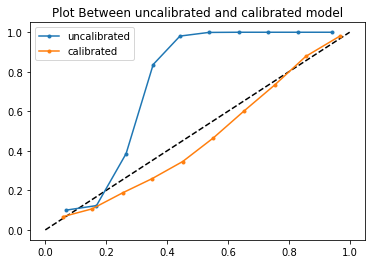

In [31]:
model = SGDClassifier(class_weight='balanced')
# uncalibrated predictions
yhat_uncalibrated = uncalibrated(model,X_train_w2v, X_test_w2v, y_train)
# calibrated predictions
yhat_calibrated = calibrated(model,X_train_w2v, X_test_w2v, y_train)
# reliability diagrams
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, yhat_uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, yhat_calibrated, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.',label = 'uncalibrated')
plt.plot(mpv_calibrated, fop_calibrated, marker='.',label = 'calibrated')
plt.legend()
plt.title("Plot Between uncalibrated and calibrated model")
plt.show()

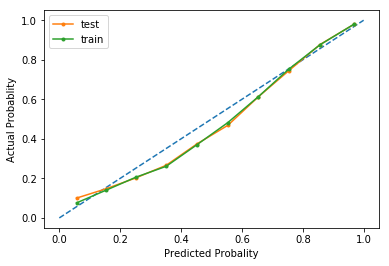

In [32]:
ccv = CalibratedClassifierCV(model,method='sigmoid',cv=10)
ccv.fit(X_train_w2v ,y_train)

prob_test = ccv.predict_proba(X_test_w2v)[:, 1]
fop_test, mpv_test = calibration_curve(y_test, prob_test, n_bins=10, normalize=True)

prob_train = ccv.predict_proba(X_train_w2v)[:, 1]
fop_train, mpv_train = calibration_curve(y_train, prob_train, n_bins=10, normalize=True)

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv_test, fop_test, marker='.',label = 'test')
plt.plot(mpv_train, fop_train, marker='.' , label ='train')
plt.xlabel('Predicted Probality')
plt.ylabel('Actual Probablity')
plt.legend()
plt.show()

### Hyperparameter plot

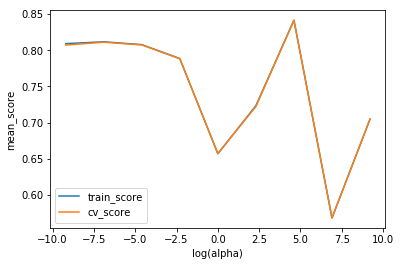

In [54]:
model_w2v = SGDClassifier(class_weight='balanced')
plot(model_w2v,X_train_w2v,y_train)

In [92]:
parameters = ccv.get_params()
parameters['base_estimator__alpha']
modelw2v =SGDClassifier(alpha = 0.0001 ,class_weight='balanced')
modelw2v.fit(X_train_w2v,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

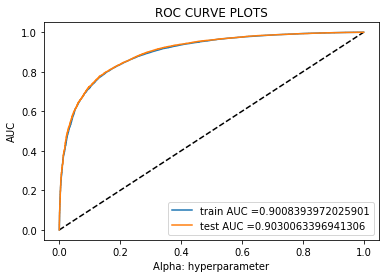

In [93]:
roc_calibrated(modelw2v,X_train_w2v, X_test_w2v, y_train,y_test)

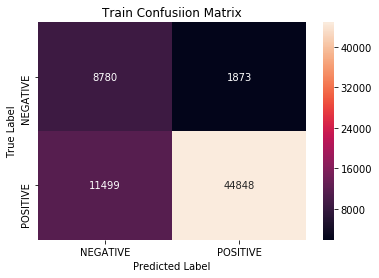

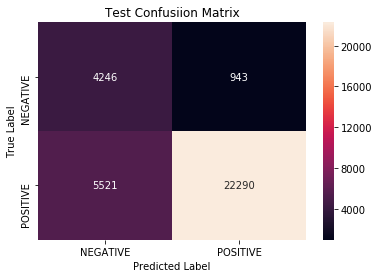

In [34]:
#ploting Confusion matrix
confusionmatrix(model,X_train_w2v,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
#ploting Confusion matrix
confusionmatrix(model,X_test_w2v,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Classification Report

In [35]:
print("Classification Report: \n")
y_pred=model.predict(X_test_w2v)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.43      0.82      0.57      5189
           1       0.96      0.80      0.87     27811

   micro avg       0.80      0.80      0.80     33000
   macro avg       0.70      0.81      0.72     33000
weighted avg       0.88      0.80      0.83     33000



## RBF TF-IDF Word2Vec

In [32]:
model = SVC(class_weight='balanced')
gsv = findbestparameter(model,A_train_w2v,b_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  8.1min finished


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  8.9min finished


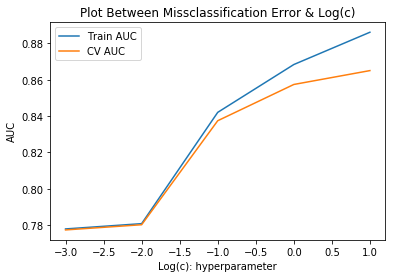

In [38]:
X = A_train_w2v
y = b_train
plot_auc(model,X,y)

### Training the model

In [34]:
rbf_model = SVC(C=1,gamma=1,class_weight='balanced',probability=True) 
rbf_model.fit(A_train_w2v,b_train)

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Confusion Matrix

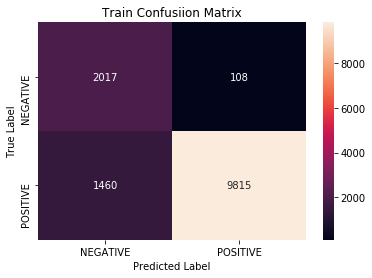

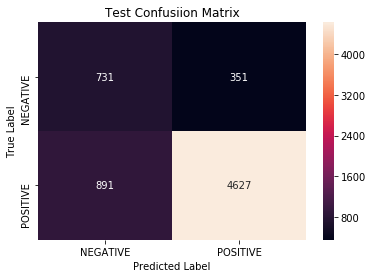

In [39]:
#ploting Confusion matrix
confusionmatrix(rbf_model,A_train_w2v,b_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
#ploting Confusion matrix
confusionmatrix(rbf_model,A_test_w2v,b_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC-AUC Curve

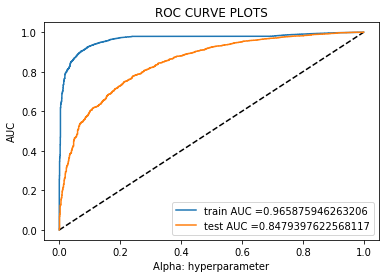

In [40]:
plot_auc_roc(rbf_model,A_train_w2v,A_test_w2v,b_train,b_test)

### Classification Report

In [41]:
print("Classification Report: \n")
y_pred=rbf_model.predict(A_test_w2v)
print(classification_report(b_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.45      0.68      0.54      1082
           1       0.93      0.84      0.88      5518

   micro avg       0.81      0.81      0.81      6600
   macro avg       0.69      0.76      0.71      6600
weighted avg       0.85      0.81      0.83      6600



# Observations

## Linear Kernel

In [94]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "hyperparameter(alpha)","Train AUC","Test AUC","f1-Score"]

x.add_row(["BOW",0.0001,0.91,0.91,0.84])
x.add_row(["TF-IDF",0.0001,0.96,0.94,0.89])
x.add_row(["Avg W2V",0.0001,0.90,0.90,0.76])
x.add_row(["TF-IDF W2V",0.0001,0.89,0.90,0.83])

print(x)

+------------+-----------------------+-----------+----------+----------+
| Vectorizer | hyperparameter(alpha) | Train AUC | Test AUC | f1-Score |
+------------+-----------------------+-----------+----------+----------+
|    BOW     |         0.0001        |    0.91   |   0.91   |   0.84   |
|   TF-IDF   |         0.0001        |    0.96   |   0.94   |   0.89   |
|  Avg W2V   |         0.0001        |    0.9    |   0.9    |   0.76   |
| TF-IDF W2V |         0.0001        |    0.89   |   0.9    |   0.83   |
+------------+-----------------------+-----------+----------+----------+


## RBF Kernel

In [4]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "hyperparameter(C)","Train AUC","Test AUC","f1-Score"]

x.add_row(["BOW",100,0.92,0.89,0.84])
x.add_row(["TF-IDF",100,0.92,0.88,0.82])
x.add_row(["Avg W2V",100,0.88,0.86,0.80])
x.add_row(["TF-IDF W2V",100,0.89,0.87,0.81])

print(x)

+------------+-------------------+-----------+----------+----------+
| Vectorizer | hyperparameter(C) | Train AUC | Test AUC | f1-Score |
+------------+-------------------+-----------+----------+----------+
|    BOW     |        100        |    0.92   |   0.89   |   0.84   |
|   TF-IDF   |        100        |    0.92   |   0.88   |   0.82   |
|  Avg W2V   |        100        |    0.88   |   0.86   |   0.8    |
| TF-IDF W2V |        100        |    0.89   |   0.87   |   0.81   |
+------------+-------------------+-----------+----------+----------+


1. Tf-idf Vectorizer has outperformed other vectorizers.
2. Calibrated SVC  is giving  better result than Uncalibrated
3. Since the dataset is imbalanced we used class_weight = 'balanced' attribute
4. Words like awesome , best , great etc are important in positive reviews also words like dissappoint , horrible ,refund , weak etc are important in negative class.
5. RBF Kernel SBM  has ourperformed knn , logistic regressionsand naive bayes algorithm.

# Thank You